In [1]:
%%capture
%cd ..

In [2]:
import torch
from src.model_selection.model_selection import model_selection
from src.dataset import SifimDataset
from src.plot.timeseries_analysis import plot_with_thresholds
from src.utility import fix_seed, select_device, gridsearch_generator

fix_seed()
device = select_device()

In [3]:
from src.trainer.esn_trainer import ESNTrainer
from src.model.esn import ESN

model, trainer = ESN, ESNTrainer
hyperparams_list = gridsearch_generator(
    model_reservoir_size=[100],
    model_alpha=[0.5, 0.1],
    model_input_ratio=[0.7, 0.9],
    model_spectral_radius=[0.9, 0.7],
    model_input_sparsity=[0.5],
    model_reservoir_sparsity=[0.9],
    model_regularization=[0.001],
    model_n_layers=[2, 1],
    model_washout=[100],
    model_seed=[0]
)

model_name = model.__class__.__name__


In [4]:
# dataset
noise = 0.3
tr_dataset = SifimDataset(start=0.0, end=0.6)
vl_dataset = SifimDataset(start=0.6, end=0.8, test=True, noise=noise)
ts_dataset = SifimDataset(start=0.8, end=1.0, test=True, noise=noise)
x_ts, y_ts = ts_dataset.x[:, :-1], ts_dataset.x[:, 1:]

In [5]:
# train concept anomaly_detector detector
model = model_selection(
    hyperparams_list=hyperparams_list,
    model_constructor=ESN,
    trainer_constructor=ESNTrainer,
    tr_dataset=tr_dataset,
    vl_dataset=vl_dataset,
    batch_size=32,
    shuffle=True,
    hyperparams_path=f'hyperparams/{model_name}_hyperparams.json',
    model_path=f'models/{model_name}.torch',
    tqdm=None,
    retrain=True,
)


2023-11-17 21:20:22,645 - root - INFO - Start iteration 1/16 => hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.9, 'model_input_sparsity': 0.5, 'model_reservoir_sparsity': 0.9, 'model_regularization': 0.001, 'model_n_layers': 2, 'model_washout': 100, 'model_seed': 0}
2023-11-17 21:20:22,656 - root - INFO - Start iteration 2/16 => hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.9, 'model_input_sparsity': 0.5, 'model_reservoir_sparsity': 0.9, 'model_regularization': 0.001, 'model_n_layers': 1, 'model_washout': 100, 'model_seed': 0}
2023-11-17 21:20:22,661 - root - INFO - Start iteration 3/16 => hyperparams: {'model_reservoir_size': 100, 'model_alpha': 0.5, 'model_input_ratio': 0.7, 'model_spectral_radius': 0.7, 'model_input_sparsity': 0.5, 'model_reservoir_sparsity': 0.9, 'model_regularization': 0.001, 'model_n_layers': 2, 'model_washout': 100, 'model_se

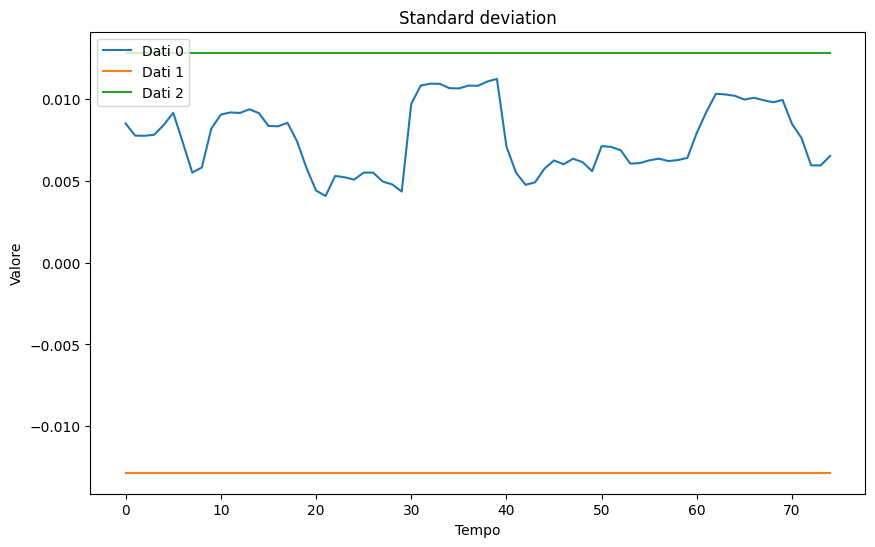

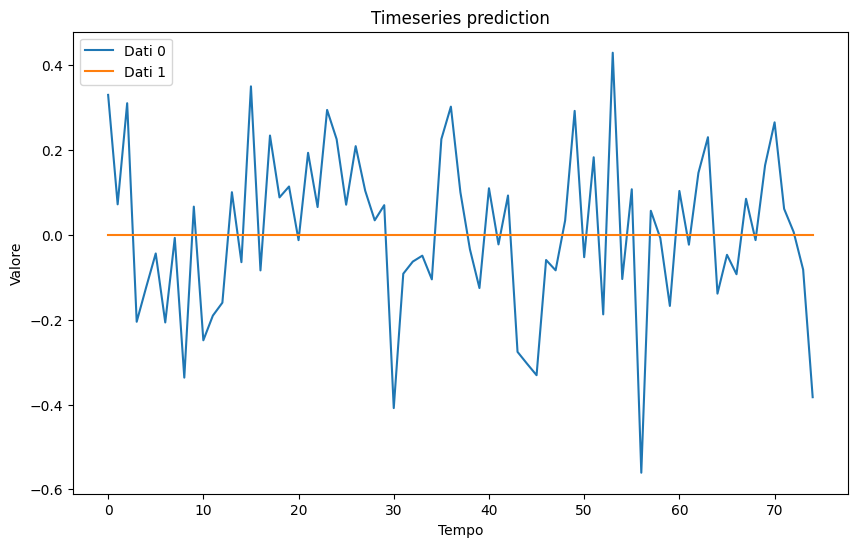

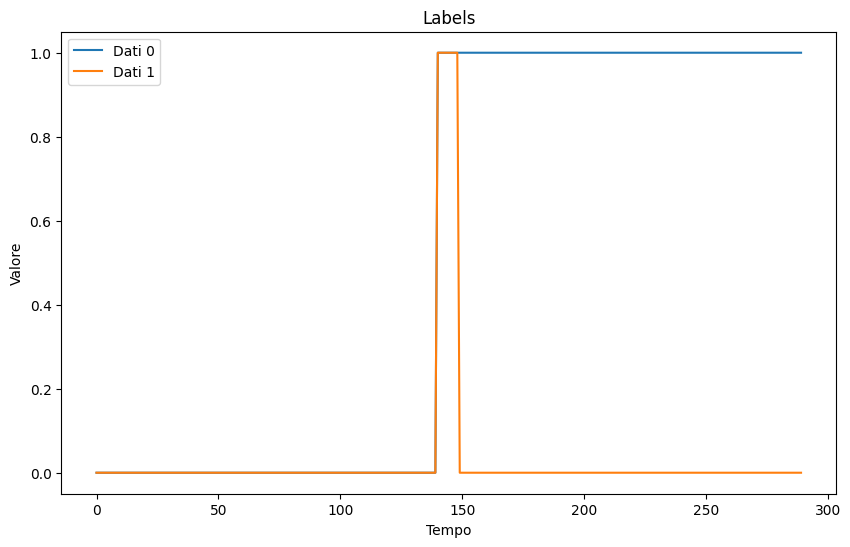

In [7]:
# test phase
ad_labels, ad_predictions, ad_std = model.predict(x_ts, y_ts)

# plot
window = 75
i = 0
f = 0

std = ad_std[i, -window:]
m2s = torch.ones_like(std) * model.sigma.item() * (-2)
p2s = torch.ones_like(std) * model.sigma.item() * (+2)
plot_with_thresholds('Standard deviation', [std, m2s, p2s])  # standard deviation

y, p = ts_dataset.x[i, -window:, f], ad_predictions[i, -window:, f]
plot_with_thresholds('Timeseries prediction', [y, p])  # timeseries and prediction of lstm

plot_with_thresholds('Labels', [ts_dataset.y[i, -ad_labels.shape[1]:], ad_labels[i]])  # labels